In [ ]:
from google.colab import drive
drive.mount('/content/drive')

BASE_DIR = "/content/drive/MyDrive/all_extracted_logs"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ================================================================
# NUKE & REINSTALL  –  run once, then *restart the runtime*
# ================================================================
!pip uninstall -y -q numpy pandas scipy scikit-learn matplotlib seaborn plotly xarray umap-learn hdbscan

In [ ]:


# Compatible pin set (Python 3.11 wheels exist for all of these)
!pip install --quiet \
    numpy==1.26.4 \
    pandas==2.2.2 \
    scipy==1.13.0 \
    scikit-learn==1.4.2 \
    matplotlib==3.8.4 \
    seaborn==0.13.2 \
    plotly==5.22.0 \
    xarray==2023.12.0 \
    umap-learn==0.5.5 \
    hdbscan==0.8.33 \
    tqdm==4.66.4 \
    openpyxl==3.1.2 \
    openai==1.30.0

# Install a Parquet engine
!pip install --quiet pyarrow==15.0.2   # or any 15.x/14.x version

print("✅  pyarrow installed — now re-run the cell that reads *.parquet files.")

print("✅  Fresh, compatible stack installed — NOW restart runtime (Ctrl+M .)")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11/11 [umap-learn]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.0 which is incompatible.
cuml-cu12 25.6.0 requires scikit-learn>=1.5, but you have scikit-learn 1.4.2 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
✅  pyarrow installed — now re-run the cell that reads *.parquet file

In [ ]:
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import umap, hdbscan
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import pyarrow

plt.style.use("ggplot")
sns.set_context("talk")
RANDOM_STATE = 42

In [ ]:
all_facilities, all_timelines = [], []

for run in sorted(os.listdir(BASE_DIR)):
    run_dir = os.path.join(BASE_DIR, run)
    if not os.path.isdir(run_dir):
        continue

    fac_file  = os.path.join(run_dir, "facilities.parquet")
    ts_file   = os.path.join(run_dir, "agent_timelines.parquet")

    if os.path.exists(fac_file) and os.path.exists(ts_file):
        fac_df = pd.read_parquet(fac_file)
        ts_df  = pd.read_parquet(ts_file)

        fac_df["run"] = run
        ts_df["run"]  = run

        all_facilities.append(fac_df)
        all_timelines.append(ts_df)

df_fac = pd.concat(all_facilities, ignore_index=True)
df_ts  = pd.concat(all_timelines,  ignore_index=True)

print(f"Loaded {len(df_fac):,} facility rows and {len(df_ts):,} timeline rows.")

Loaded 4,987,591 facility rows and 43,350 timeline rows.


In [ ]:
# # ==== Quick peek at df_ts structure ====
# print("Columns in df_ts:")
# print(df_ts.columns.tolist())
# print("\nSample rows:")
# display(df_ts.head(3))


In [ ]:
# ---------------------------------------------------------------
# 1. Extract Boolean infected flag from infection_status dict
# ---------------------------------------------------------------
def get_infected_flag(record):
    """
    record is usually a dict like {'infected': True, 'infectious': False, ...}.
    Handles edge cases (None, already-bool, JSON-string).
    """
    if isinstance(record, dict):
        return bool(record.get("infected", False))
    if isinstance(record, str):
        # Sometimes parquet stores the dict as JSON string
        try:
            import json
            return bool(json.loads(record).get("infected", False))
        except Exception:
            return False
    # Fallback: if it’s already bool
    return bool(record)

df_ts["infected"] = df_ts["infection_status"].apply(get_infected_flag).astype(int)

# ---------------------------------------------------------------
# 2. Group-by aggregation per facility per timestep
# ---------------------------------------------------------------
agg = (df_ts
       .groupby(["run", "current_location_id", "timestep"], as_index=False)
       .agg(n_present  = ("person_id", "nunique"),
            n_infected = ("infected",   "sum")))

timesteps = np.sort(agg["timestep"].unique())
print(f"✅ Aggregated → {len(agg):,} rows · detected {len(timesteps)} timesteps.")


✅ Aggregated → 20,005 rows · detected 13 timesteps.


In [ ]:
def fill_series(df, col):
    """Return values for every timestep, NaNs→0, ordered by global timestep list."""
    return (df.set_index("timestep")[col]
              .reindex(timesteps)
              .fillna(0)
              .to_numpy())

vectors, meta = [], []

for (run, fid), grp in tqdm(agg.groupby(["run", "current_location_id"])):
    v_present  = fill_series(grp, "n_present")
    v_infected = fill_series(grp, "n_infected")
    vec        = np.concatenate([v_present, v_infected])
    vectors.append(vec)
    meta.append({"run": run, "facility_id": fid})

X        = np.vstack(vectors).astype(np.float32)
meta_df  = pd.DataFrame(meta)
print("Vector matrix shape:", X.shape)

100%|██████████| 5823/5823 [00:24<00:00, 240.96it/s]


Vector matrix shape: (5823, 26)


In [ ]:
scaler    = StandardScaler()
X_scaled  = scaler.fit_transform(X)

umap_model = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    metric="euclidean",
    random_state=RANDOM_STATE
)
X_umap = umap_model.fit_transform(X_scaled)

meta_df["umap_x"] = X_umap[:, 0]
meta_df["umap_y"] = X_umap[:, 1]



/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, metric="euclidean")
labels    = clusterer.fit_predict(X_umap)

meta_df["cluster"] = labels.astype(int)
print(meta_df["cluster"].value_counts(dropna=False).rename("facility_count"))


cluster
 2     608
-1     555
 1     307
 23    265
 18    197
      ... 
 43     12
 95     12
 85     12
 40     11
 64     10
Name: facility_count, Length: 101, dtype: int64


In [ ]:
fig = px.scatter(
    meta_df,
    x="umap_x", y="umap_y",
    color=meta_df["cluster"].astype(str),
    hover_data=["facility_id", "run"],
    title="Facility Temporal Clusters (UMAP + HDBSCAN)"
)
fig.update_layout(height=650, width=900)
fig.show()

In [ ]:
# ================================================================
# SAVE INTERACTIVE UMAP-HDBSCAN SCATTER TO STAND-ALONE HTML
# run this right after the fig.show() cell
# ================================================================
html_path = "umap_hdbscan_clusters.html"

# full_html=True  → writes a complete <html> doc
# include_plotlyjs="cdn"  → uses Plotly JS from a CDN (tiny file, works online)
# If you need 100 % offline viewing, switch to include_plotlyjs="embed"
fig.write_html(html_path, full_html=True, include_plotlyjs="embed")

print(f"✅  Interactive plot saved → {html_path}")

from google.colab import files
files.download(html_path)

✅  Interactive plot saved → umap_hdbscan_clusters.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def plot_cluster_signatures(cluster_id, max_examples=5):
    members = meta_df[meta_df["cluster"] == cluster_id].index.tolist()[:max_examples]
    for idx in members:
        vec       = X[idx]
        present   = vec[:len(timesteps)]
        infected  = vec[len(timesteps):]

        plt.figure(figsize=(14, 4))
        plt.plot(timesteps, present,   label="n_present")
        plt.plot(timesteps, infected,  label="n_infected")
        plt.title(f"Run: {meta_df.loc[idx, 'run']} ▸ Facility: {meta_df.loc[idx, 'facility_id']} ▸ Cluster: {cluster_id}")
        plt.xlabel("Timestep")
        plt.legend()
        plt.tight_layout()
        plt.show()

In [ ]:
meta_df.to_csv("facility_clusters.csv", index=False)
np.save("facility_vectors.npy", X)
print("Saved facility_clusters.csv and facility_vectors.npy")

Saved facility_clusters.csv and facility_vectors.npy


In [ ]:
# ================================================================
# Cell A  –  INSTALL OPENAI CLIENT  (adds one tiny dependency)
# ================================================================
!pip install --quiet openai==1.30.0
!pip install --upgrade openai
import os
os.environ["OPENAI_API_KEY"] = ""

  Using cached openai-1.97.1-py3-none-any.whl.metadata (29 kB)
Using cached openai-1.97.1-py3-none-any.whl (764 kB)
  Attempting uninstall: openai
    Found existing installation: openai 1.30.0
    Uninstalling openai-1.30.0:
      Successfully uninstalled openai-1.30.0


In [ ]:
!pip install --upgrade openai

In [ ]:
import os, pprint, itertools

def tree(root, levels=2):
    out = []
    for dirpath, dirnames, filenames in os.walk(root):
        depth = dirpath[len(root):].count(os.sep)
        if depth > levels:      # limit depth
            continue
        indent = " " * 2 * depth
        for f in filenames:
            out.append(f"{indent}{os.path.join(dirpath, f)}")
    return out

pprint.pp(tree(BASE_DIR, levels=3)[:50])   # show first 50 paths

['  /content/drive/MyDrive/all_extracted_logs/extracted_run171/agents.parquet',
 '  '
 '/content/drive/MyDrive/all_extracted_logs/extracted_run171/infection_chains.json',
 '  '
 '/content/drive/MyDrive/all_extracted_logs/extracted_run171/infections.parquet',
 '  '
 '/content/drive/MyDrive/all_extracted_logs/extracted_run171/agent_timelines.parquet',
 '  '
 '/content/drive/MyDrive/all_extracted_logs/extracted_run171/facilities.parquet',
 '  '
 '/content/drive/MyDrive/all_extracted_logs/extracted_run147/infection_chains.json',
 '  '
 '/content/drive/MyDrive/all_extracted_logs/extracted_run147/infections.parquet',
 '  /content/drive/MyDrive/all_extracted_logs/extracted_run147/agents.parquet',
 '  '
 '/content/drive/MyDrive/all_extracted_logs/extracted_run147/agent_timelines.parquet',
 '  '
 '/content/drive/MyDrive/all_extracted_logs/extracted_run147/facilities.parquet',
 '  '
 '/content/drive/MyDrive/all_extracted_logs/extracted_run185/infections.parquet',
 '  /content/drive/MyDrive/all_e

In [ ]:
# ================================================================
# Cell B  –  LOAD *infection_logs.parquet* FOR EVERY RUN
#           → builds a single DataFrame: inf_events
# ================================================================
import glob

# --- infection loader (patched) ---------------------------------
infection_events = []
for run in sorted(os.listdir(BASE_DIR)):
    run_dir  = os.path.join(BASE_DIR, run)
    inf_path = os.path.join(run_dir, "infections.parquet")
    if os.path.exists(inf_path):
        df_inf = (pd.read_parquet(inf_path,
                                  columns=["timestep", "location_id"])
                  .rename(columns={"location_id": "current_location_id"}))
        df_inf["run"] = run
        infection_events.append(df_inf)


if not infection_events:
    raise FileNotFoundError("⚠️  No infection_logs.parquet files located!")

inf_events = pd.concat(infection_events, ignore_index=True)
print(f"Loaded {len(inf_events):,} infection-event rows "
      f"from {inf_events['run'].nunique()} runs.")


Loaded 14,200 infection-event rows from 200 runs.


In [ ]:
# ================================================================
# Cell C  –  COMPUTE FACILITY-LEVEL KPIs
#           • infections   • person-minutes   • attack_rate
# ================================================================
STEP_MINUTES = 10          # 1 simulation timestep = 10 real minutes

# (1) total infections per (run, facility)
inf_fac = (inf_events
           .groupby(["run", "current_location_id"], as_index=False)
           .size()
           .rename(columns={"size": "n_infections"}))

# (2) person-minutes per (run, facility)
pm_fac = (agg
          .groupby(["run", "current_location_id"], as_index=False)
          .agg(person_minutes=("n_present", "sum")))
pm_fac["person_minutes"] *= STEP_MINUTES

# (3) combine → facility_kpi
facility_kpi = (inf_fac
                .merge(pm_fac,
                       on=["run", "current_location_id"],
                       how="outer")
                .fillna(0))
facility_kpi["attack_rate"] = (
    facility_kpi["n_infections"] /
    facility_kpi["person_minutes"].clip(lower=1)
)

print(f"Computed KPIs for {len(facility_kpi):,} facility-instances.")


Computed KPIs for 7,048 facility-instances.


In [ ]:
# ================================================================
# Cell D  –  MERGE KPIs INTO meta_df  +  FLAG SUPERSPREADERS
#           • attack_rate percentile > 95 → superspreader
#           Saves facility_clusters_kpi.csv
# ================================================================
SS_THRESHOLD = facility_kpi["attack_rate"].quantile(0.95)
facility_kpi["is_superspreader"] = facility_kpi["attack_rate"] > SS_THRESHOLD

meta_df = (meta_df
           .merge(facility_kpi,
                  left_on=["run", "facility_id"],
                  right_on=["run", "current_location_id"],
                  how="left"))

meta_df.to_csv("facility_clusters_kpi.csv", index=False)
print("✅  Added KPI columns → facility_clusters_kpi.csv created.")


✅  Added KPI columns → facility_clusters_kpi.csv created.


In [ ]:
# ================================================================
# Cell E  –  CLUSTER-LEVEL SUMMARY  (share of infections, mean AR)
#           Stores DataFrame cluster_summary for later use.
# ================================================================
cluster_summary = (meta_df
                   .groupby("cluster", as_index=False)
                   .agg(total_infections=("n_infections",   "sum"),
                        total_pm        =("person_minutes", "sum"),
                        n_facilities    =("facility_id",    "count")))
cluster_summary["share_of_infections"] = (
    cluster_summary["total_infections"] /
    cluster_summary["total_infections"].sum()
)
cluster_summary["attack_rate_mean"] = (
    cluster_summary["total_infections"] /
    cluster_summary["total_pm"].clip(lower=1)
)

display(cluster_summary.head())


,cluster,total_infections,total_pm,n_facilities,share_of_infections,attack_rate_mean
0,-1,1910.0,81390.0,555,0.182933,0.023467
1,0,20.0,1050.0,51,0.001916,0.019048
2,1,89.0,3070.0,307,0.008524,0.028990
3,2,562.0,6080.0,608,0.053826,0.092434
4,3,22.0,1140.0,38,0.002107,0.019298


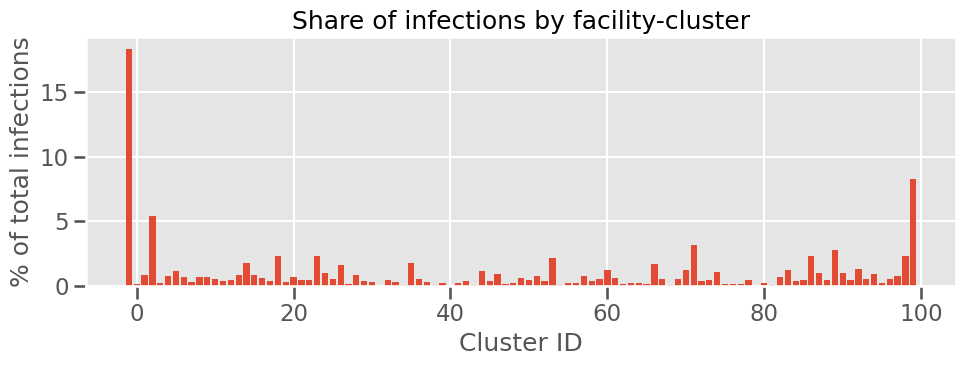

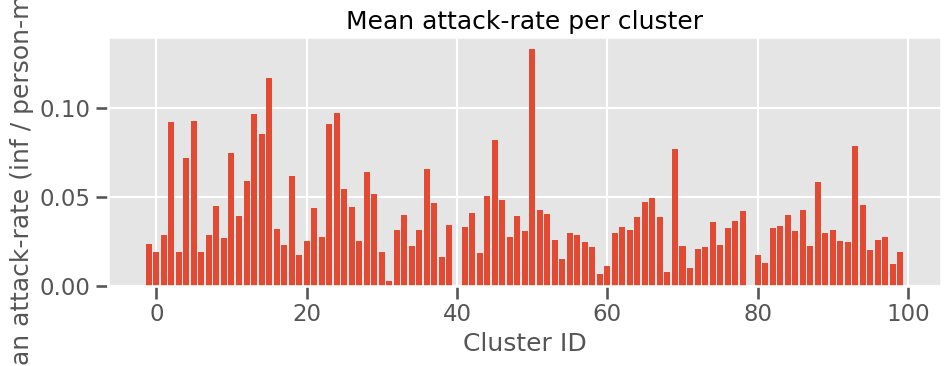

📊  PNG charts saved.


In [ ]:
# ================================================================
# Cell F  –  STATIC BAR CHARTS  (PNG files for reports)
#           • infection share by cluster
#           • mean attack-rate by cluster
# ================================================================
plt.figure(figsize=(10, 4))
plt.bar(cluster_summary["cluster"],
        cluster_summary["share_of_infections"] * 100)
plt.ylabel("% of total infections")
plt.xlabel("Cluster ID")
plt.title("Share of infections by facility-cluster")
plt.tight_layout()
plt.savefig("cluster_infection_share.png", dpi=150)
plt.show()

plt.figure(figsize=(10, 4))
plt.bar(cluster_summary["cluster"],
        cluster_summary["attack_rate_mean"])
plt.ylabel("Mean attack-rate (inf / person-minute)")
plt.xlabel("Cluster ID")
plt.title("Mean attack-rate per cluster")
plt.tight_layout()
plt.savefig("cluster_attack_rate.png", dpi=150)
plt.show()
print("📊  PNG charts saved.")

In [ ]:
# ================================================================
# Cell G  –  LLM NARRATIVE GENERATOR (OpenAI v1 API)
#           Function generate_cluster_report(cluster_id)
#           → writes cluster_<ID>_report.md
# ================================================================
import os, json, textwrap
from openai import OpenAI                     # v1 client
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

def generate_cluster_report(cluster_id: int,
                            model: str = "gpt-4o-mini",
                            temperature: float = 0.3):
    """Generate a short, human-readable insight for one cluster."""
    if cluster_id not in cluster_summary["cluster"].values:
        raise ValueError(f"Cluster {cluster_id} not found.")

    row = cluster_summary.loc[cluster_summary["cluster"] == cluster_id].iloc[0]
    stats = {
        "cluster_id"         : int(cluster_id),
        "n_facilities"       : int(row["n_facilities"]),
        "share_of_infections": float(row["share_of_infections"]),
        "attack_rate_mean"   : float(row["attack_rate_mean"])
    }

    prompt = textwrap.dedent(f"""
        You are an epidemiology analyst.
        Given this JSON summary of a facility cluster, write:
        1. Two short sentences explaining its risk profile.
        2. Two concise non-pharmaceutical intervention suggestions.

        JSON:
        {json.dumps(stats, indent=2)}
    """)

    resp = client.chat.completions.create(
        model=model,
        temperature=temperature,
        messages=[{"role": "user", "content": prompt}]
    )

    report = resp.choices[0].message.content.strip()
    out_path = f"cluster_{cluster_id}_report.md"
    with open(out_path, "w") as f:
        f.write(report)

    print(f"📝  Report written to {out_path}\n")
    print(report)


In [ ]:
for cid in cluster_summary["cluster"].unique():
    try:
        generate_cluster_report(int(cid))
    except Exception as e:
        print(f"⚠️  Skipped cluster {cid}: {e}")
print("✅  All cluster reports generated.")

📝  Report written to cluster_-1_report.md

1. The facility cluster exhibits a moderate risk profile, with 18.3% of infections attributed to it and a mean attack rate of 2.35%. This indicates a significant potential for transmission within the facilities involved. 

2. Implement regular screening and testing protocols for staff and residents to identify and isolate cases early. Additionally, enhance ventilation and promote mask-wearing in shared spaces to reduce the risk of airborne transmission.
📝  Report written to cluster_0_report.md

1. The facility cluster has a low share of infections at approximately 0.19%, indicating a relatively low risk of widespread transmission. However, with an average attack rate of about 1.9%, there remains a potential for localized outbreaks that should be monitored closely. 

2. Implement regular screening and testing for staff and residents to quickly identify and isolate cases. Enhance hygiene protocols, including frequent disinfection of high-touch s

In [ ]:
# ================================================================
# Cell H  –  QUICK OVERVIEW HELPER
#           • prints top superspreader facilities
#           • shows superspreader counts per cluster
# ================================================================
def print_superspreader_overview(top_n: int = 10):
    top_ss = (meta_df
              .sort_values("attack_rate", ascending=False)
              .head(top_n)[["facility_id", "run", "cluster", "attack_rate"]])
    print(f"Top {top_n} superspreader candidates:")
    display(top_ss)

    ss_per_cluster = (meta_df.groupby("cluster")["is_superspreader"].sum()
                      .rename("superspreader_count"))
    print("\nSuperspreader counts per cluster:")
    display(ss_per_cluster)

# Example quick call (can remove or comment out):
# print_superspreader_overview(5)

In [ ]:
#IGNORE for now
def cluster_stats_json(cluster_id):
    sub = meta_df[meta_df["cluster"] == cluster_id]
    stats = {
        "cluster_id"      : int(cluster_id),
        "n_facilities"    : int(len(sub)),
        "n_runs"          : int(sub["run"].nunique()),
        "sample_facilities": sub["facility_id"].unique()[:5].tolist()
    }
    return json.dumps(stats, indent=2)